# Simulated Annealing

1. Introduzione
2. Iperparametri
    - Dimensione mossa ($\epsilon$)
    - Temperatura iniziale e fattore di raffreddamento ($T_0$ e $ \alpha$)
    - Bound
3. Risultati
    - MNIST
    - Fashion-MNIST
    - CIFAR10
4. Conclusioni

## 1. Introduzione

Alcuni import e funzioni di supporto per il notebook.

In [2]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random as rm
import numpy as np
import time
import copy
import math

# Add the sibling folders
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
import src.utils as ut

# Plot libraries and tables
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import glob

In [3]:
def read_folder(folder):    
    results = {}
    for filename in glob.glob(f'{folder}/*.npz'):
        filename_filtered = '.'.join(filename.split("/")[-1].split(".")[0:-1])
        results.update({filename_filtered: np.load(filename)})
    return results

In [11]:
def generate_move(epsilon):
    h = torch.tensor([], dtype=torch.float32).cuda()
    for k, param in enumerate(net.parameters()):
        tensor_size = param.data.size()
        move = torch.zeros(tensor_size).cuda()
        move.normal_(std=epsilon)
        h = torch.cat((h, move.view(-1)), dim=-1)
    return h.tolist()

Come descritto nella mail iniziale ad ogni iterazione vengono valutate entrambe le possibile mosse $ w \pm \epsilon \Delta(w) $. Se una delle due mosse decresce la funzione obiettivo, viene accettata la migliore, altrimenti si utilizza la formula esponenziale di Simulated Annealing per decidere se accettare o meno.

L'algoritmo nella sua versione stocastica utilizza lo stesso epsilon e la stessa temperatura per una epoca. Ad ogni conclusione vengono aggiornati $ \epsilon $ e temperatura.
- $ \epsilon $ viene ridotto di un fattore 10 solo se in un'epoca vi sono un numero insufficiente di mosse migliorative, ovvero
\begin{align*} \frac{num\_mosse\_migliorative}{num\_mosse\_totali} < bound   \end{align*}
Questo per raggiungere l'effetto di annealing di $ \epsilon $. Solitamente per il bound ho utilizzato valori pari a 0.6, 0.7 (un'analisi più dettagliata in seguito). Ho utilizato un fattore 10, similmente a quanto viene fatto nello scheduled SGD, per semplificare il set di iperparametri possibili.
- La temperatura viene moltiplicata per un fattore di raffreddamento  $ \alpha $ ($ 0 < \alpha < 1$) ad ogni conclusione di epoca

L'implementazione finale è qui presentata.

In [5]:
def stochastic_simulated_annealing(trainloader, model, epsilon, T, gpu=True):
    model.train()
    
    not_accepted, accepted = 0, 0
    probabilities = []
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        if gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        initial_loss = ut.test_minibatch(inputs, labels, model)[0]
        
        # List used to keep the move to get back to the initial point
        inverse = []

        # First move
        for param in model.parameters():
            # Replicate the tensor
            tensor_size = param.data.size()
            move = torch.zeros(tensor_size)
            # Send it to the GPU
            if gpu:
                move = move.cuda()
            # Generate move
            move.normal_(std=epsilon)
            # Step back is saved
            inverse.append(move.mul(-1)) 
            # Move the parameters
            param.data.add_(move)
        # Evaluate the loss 
        first_loss = ut.test_minibatch(inputs, labels, model)[0]

        # Second move
        for k, param in enumerate(model.parameters()):
            param.data.add_(inverse[k].mul(2))
            inverse[k].mul_(-1)
        second_loss = ut.test_minibatch(inputs, labels, model)[0]

        # Get back if the first move is better
        if first_loss < second_loss:
            for k, param in enumerate(model.parameters()):
                param.data.add_(inverse[k].mul(2))
                inverse[k].mul_(-1)
            new_loss = first_loss
        else: new_loss = second_loss
        
        if new_loss > initial_loss:
            probabilities.append(math.exp(- (new_loss - initial_loss) / T))
        
        # Reject worse solution according to the standard formula
        if new_loss > initial_loss and math.exp(- (new_loss - initial_loss) / T) < rm.random():
            not_accepted += 1
            for k, param in enumerate(model.parameters()):
                param.data.add_(inverse[k])
            new_loss = initial_loss
        elif new_loss > initial_loss:
            accepted += 1
        
        del move, inverse, inputs, labels
        
    return not_accepted, accepted, probabilities

## 2. Parametri

### Dimensioni mossa
La mossa viene generata tramite distribuzione normale. Per capire la dimensione corretta è utile confrontare la distribuzione del gradiente con la distribuzione della mossa random di SA. Nei grafici seguenti viene mostrato lo stesso gradiente ottenuto dopo due epoche di training in confronto alla mossa random $ \Delta(w) $ con differenti valori di $ \epsilon $ (0.001, 0.0001, 0.00001).

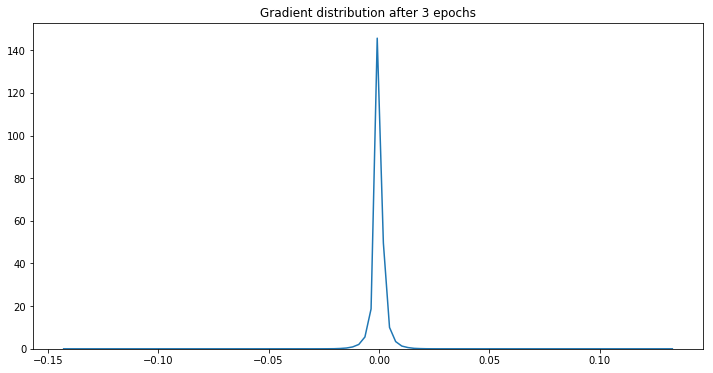

In [21]:
net = ut.load_net(net='convnet', dataset_name='fashion-mnist').cuda()
g = torch.tensor([], dtype=torch.float32).cuda()

train_loader, test_loader = ut.load_dataset(dataset_name='fashion-mnist', minibatch=512, drop_last=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
for epoch in range(2):
    ut.train(train_loader, net, optimizer, criterion, 1)

for k, param in enumerate(net.parameters()):
    g = torch.cat((g, param.grad.data.clone().view(-1)), dim=-1)

fig, ax = plt.subplots(figsize=(12, 6))
gradient = g.tolist()

plt.title('Gradient distribution after 3 epochs')
sns.distplot(gradient, hist=False)
plt.show()

In [22]:
e3 = generate_move(1e-3)
e4 = generate_move(1e-4)
e5 = generate_move(1e-5)

# Scale the gradient
grad = [g * 0.01 for g in gradient]

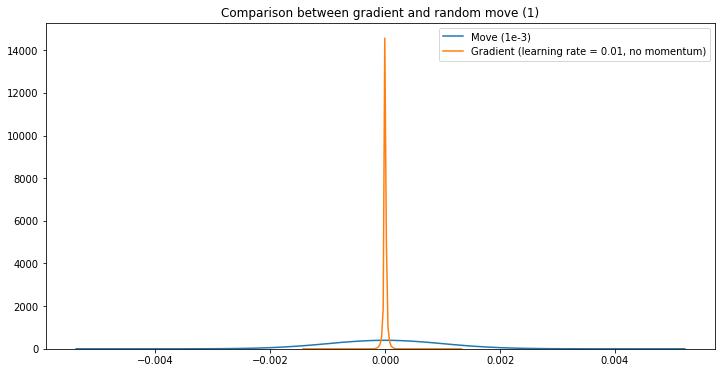

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Comparison between gradient and random move (1)')
sns.distplot(e3, hist=False, label='Move (1e-3)')
sns.distplot(grad, hist=False, label='Gradient (learning rate = 0.01, no momentum)')
plt.legend()
plt.show()

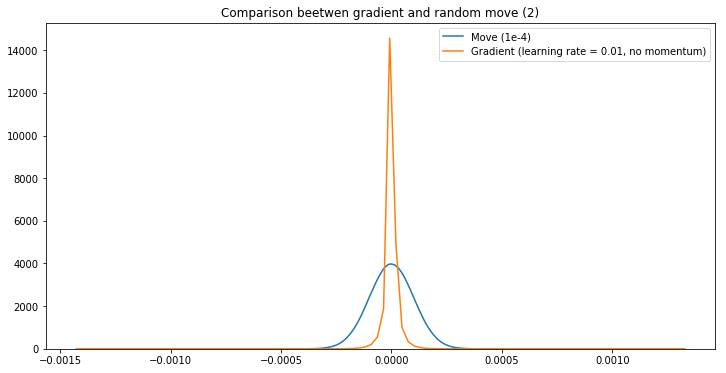

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Comparison beetwen gradient and random move (2)')
sns.distplot(e4, hist=False, label='Move (1e-4)')
sns.distplot(grad, hist=False, label='Gradient (learning rate = 0.01, no momentum)')
plt.legend()
plt.show() 

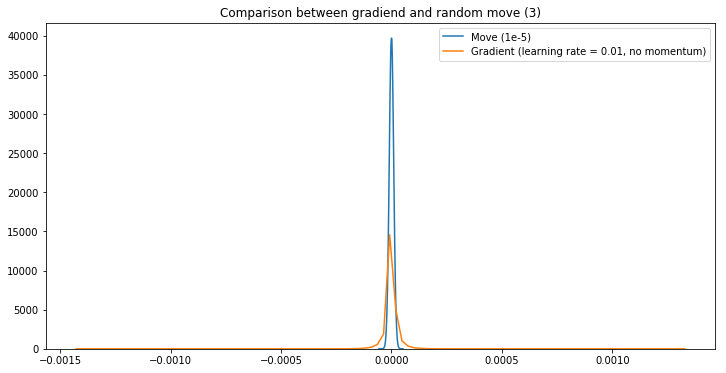

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Comparison between gradiend and random move (3)')
sns.distplot(e5, hist=False, label='Move (1e-5)')
sns.distplot(grad, hist=False, label='Gradient (learning rate = 0.01, no momentum)')
plt.legend()
plt.show()

Nei test svolti ho notato che utlizzare una mossa con valori più ampi (1e-3) su determinati dataset permette di velocizzare l'allenamento nelle prime epoche, ma tende rapidamente ad effetti oscillatori. Dunque ho svolto tutti i test facendo partire da 1e-3 per poi diminuire automaticamente.
Forzare lo stesso valore di $\epsilon$ porta ad effetti peggiorativi dopo poche epoche. Un esempio nel grafico precedente, dove già alla 15esima epoca la funzione obiettivo inizia a crescere.

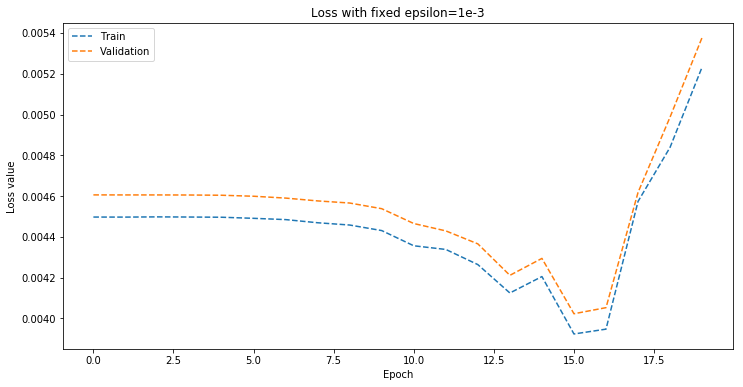

In [29]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/epsilon_costante')
fig, ax = plt.subplots(figsize=(12,6))
for name, result in results.items():
    n_epochs = 20
    ax.plot(np.arange(0, n_epochs), result['train_loss'][0:n_epochs], '--', label='Train')
    ax.plot(np.arange(0, n_epochs), result['validation_loss'][0:n_epochs], '--', label='Validation')
ax.legend()
plt.title('Loss with fixed epsilon=1e-3')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

### Bound
Quando le mosse peggiorative diventano eccessive $\epsilon$ viene diminuito. Un esempio di come avviene il drop di $\epsilon$: la barra verticale rossa delimita il passaggio da $\epsilon=0.001$ a  $\epsilon=0.0001$. Si ricorda che per mossa migliorativa si intende una mossa in cui uno tra $w \pm \Delta(w)$ permette di decrescere la funzione obiettivo.

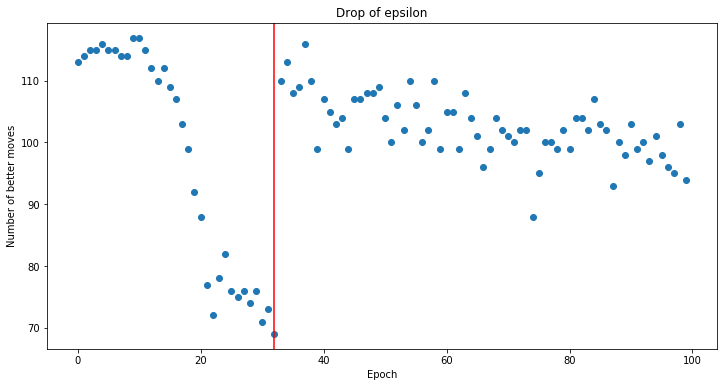

In [46]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/run__2019-01-28_14:24:33')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    
    n_epochs = 100
    na = result['na']
    ac = result['ac']
    ax.scatter(np.arange(0, n_epochs), np.full(n_epochs, 118) - (np.asarray(na)[0:n_epochs] + np.asarray(ac)[0:n_epochs]))
    for drop in drop_eps.keys():
        plt.axvline(x=drop, color='red')

plt.xlabel('Epoch')
plt.ylabel('Number of better moves')
plt.title('Drop of epsilon')
plt.show()

Diversi valori sono stati testati per trovare il migliore tradeoff che minimizzasse la velocità di training.

In [30]:
results = read_folder('../../results/SSA/mnist/convnet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name)

plt.title('Bound comparison (ConvNet on MNIST)')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
ax.legend()

mpld3.display()

Si può notare come utilizzare delle soglie basse, quindi più restrittive porti a mantenere $\epsilon$, generando effetti oscillatori che erano stati individuati anche nel grafico 'Loss with fixed epsilon 1e-3'. Seppur nelle prime epoche sia maggiormente veloce, rapidamente si presentano effetti peggiorativi. Un valore di $0.5$ sembra raggiungere la migliore performance tra velocità e accuratezza. Un valore del bound pari a 0.7, seppure più lento raggiunge le stesse performance.

### Temperatura iniziale e fattore di raffreddamento
La funzione di annealing è stata studiata per dividere approssitivamente le mille epoche a metà tra diversificazione e intensificazione. Nei test $ T_O $ è sempre stato posto ad 1, mentre $ \alpha $ pari a 0.97 per un lento raffreddamento. Considerando che un solo ciclo è stato utilizzato e che il numero di epoche è piuttosto elevato, il fattore di normalizzazione non è stato necessario. Un esempio di distribuzione delle probabilità per ogni iterazione nel grafico seguente.

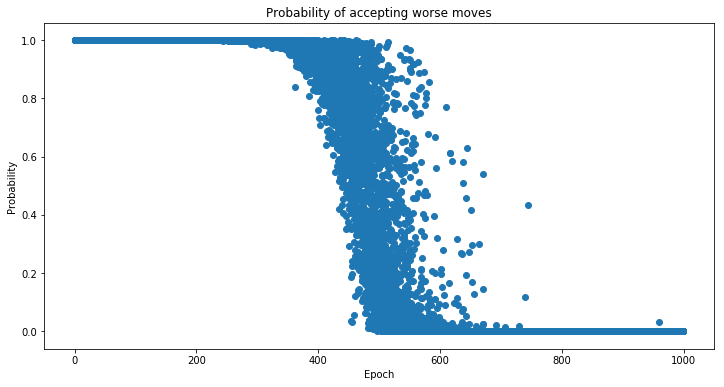

In [9]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/run__2019-01-28_14:24:33')
fig, ax = plt.subplots(figsize=(12,6))
for name, result in results.items():
    probabilities = result['probabilities'][()]
    x, y = zip(*((k, float(x)) for k in probabilities for x in probabilities[k]))
    n_epochs = len(result['train_accuracy'])
    ax.scatter(x, y, label=name)
plt.title('Probability of accepting worse moves')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.show()

Un esempio che raggruppa tutto: gli effetti di annealing e il drop di $\epsilon$.

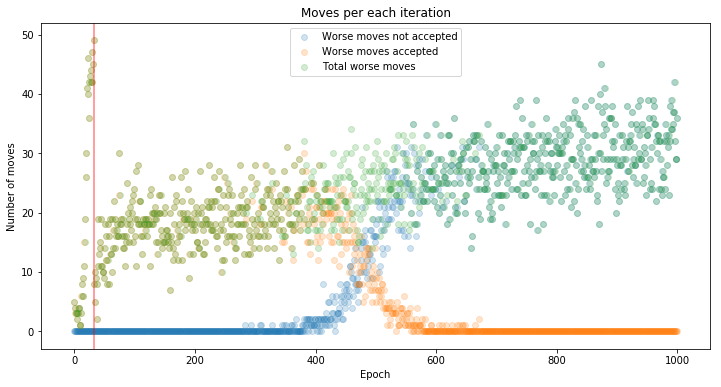

In [47]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/run__2019-01-28_14:24:33')
fig, ax = plt.subplots(figsize=(12, 6))

for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    na = result['na']
    ac = result['ac']

    ax.scatter(np.arange(0, len(na)) - 0.2, na, label='Worse moves not accepted', alpha=0.2)
    ax.scatter(np.arange(0, len(ac)), ac, label='Worse moves accepted', alpha=0.2)
    ax.scatter(np.arange(0, len(na)) + 0.2, np.asarray(na) + np.asarray(ac), label='Total worse moves', alpha=0.2)

    for drop in drop_eps.keys():
        plt.axvline(x=drop, color='red', alpha=0.5)

ax.legend()
plt.title('Moves per each iteration')
plt.xlabel('Epoch')
plt.ylabel('Number of moves')
plt.show()

## 3. Risultati

### MNIST

I risultati che le avevo già mandato su una rete convoluzionale a due livelli + due livelli lineari. Essendo un dataset piuttosto semplice, non ho svolto ulteriori test con altre reti. In questi testi SSA ha raggiunto una accuracy del $96\%$ circa contro il $99\%$ di SGD.

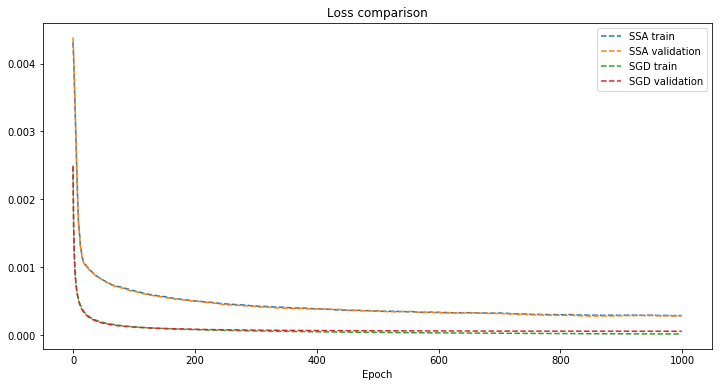

In [52]:
results = read_folder('../../results/SSA/mnist/convnet/SSAvsSGDonConvNet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name+' train')
    ax.plot(np.arange(0, n_epochs), result['validation_loss'], '--', label=name+' validation')

    #plt.axvline(x=9, color='red', alpha=0.2)
plt.title('Loss comparison')
plt.xlabel('Epoch')
ax.legend()
plt.show()

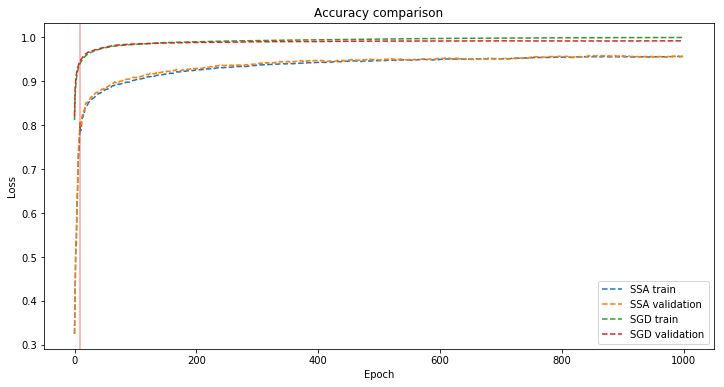

In [51]:
results = read_folder('../../results/SSA/mnist/convnet/SSAvsSGDonConvNet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_accuracy'])
    ax.plot(np.arange(0, n_epochs), result['train_accuracy'], '--', label=name+' train')
    ax.plot(np.arange(0, n_epochs), result['validation_accuracy'], '--', label=name+' validation')

    plt.axvline(x=9, color='red', alpha=0.2)
plt.title('Accuracy comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

### Fashion-MNIST

In questi grafici l'andamento delle curve di training è leggermente rumoroso, poichè è stata utilizzata la funzione che utilizza sono un sample dei minibatch per velocizzare il calcolo. Nel secondo grafico si può notare come il drop di epsilon sia avvenuto molto presto a differenza del grafico precedente su MNIST, rallentando così l'allenamento.

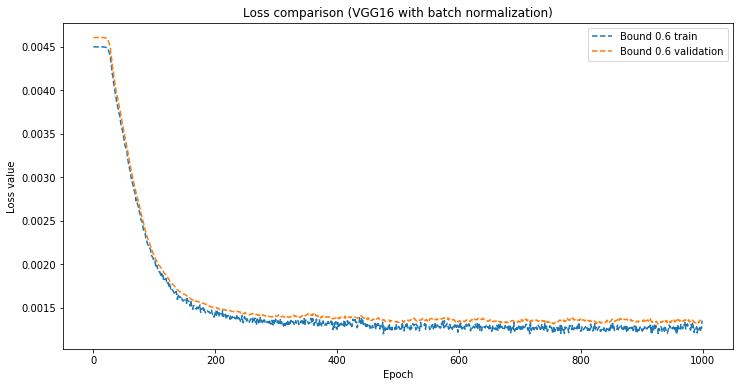

In [53]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name+' train')
    ax.plot(np.arange(0, n_epochs), result['validation_loss'], '--', label=name+' validation')

    #plt.axvline(x=9, color='red', alpha=0.2)
plt.title('Loss comparison (VGG16 with batch normalization)')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
ax.legend()
plt.show()

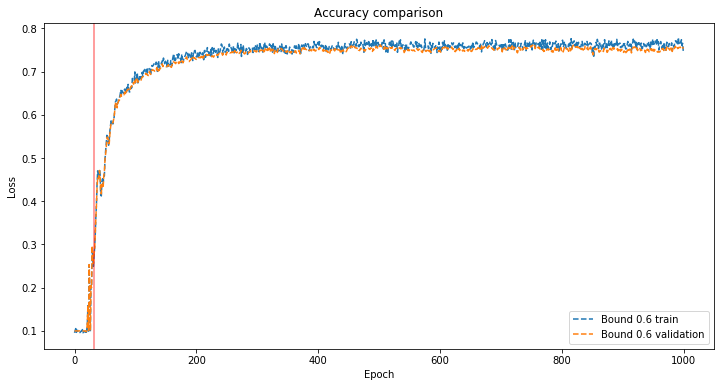

In [49]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    n_epochs = len(result['train_accuracy'])
    ax.plot(np.arange(0, n_epochs), result['train_accuracy'], '--', label=name+' train')
    ax.plot(np.arange(0, n_epochs), result['validation_accuracy'], '--', label=name+' validation')

    for drop in drop_eps.keys():
        plt.axvline(x=drop, color='red', alpha=0.5)
plt.title('Accuracy comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

### CIFAR10

In questo caso il drop avviene pressoché immediatamente. Su CIFAR10 l'allenamento sembra essere molto difficile, SA mostra difficoltà a scalare a dataset più complessi.

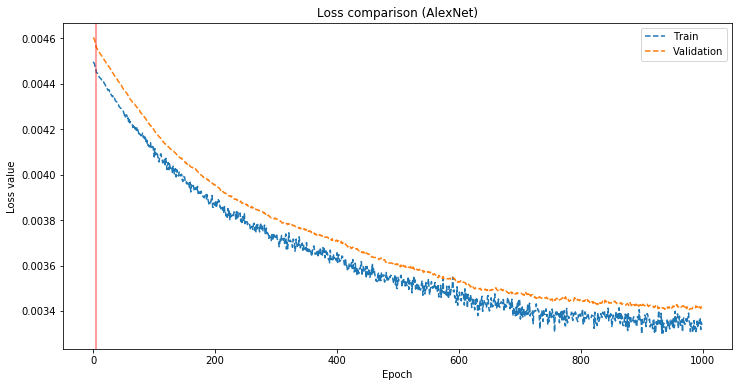

In [27]:
results = read_folder('../../results/SSA/cifar10/alexnet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    n_epochs = len(result['train_loss'])
    line, =ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label='Train')
    ax.plot(np.arange(0, n_epochs), result['validation_loss'], '--', label='Validation')

    for drop in drop_eps.keys():
        plt.axvline(x=drop, color='red', alpha=0.5)
plt.title('Loss comparison (AlexNet)')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
ax.legend()
plt.show()

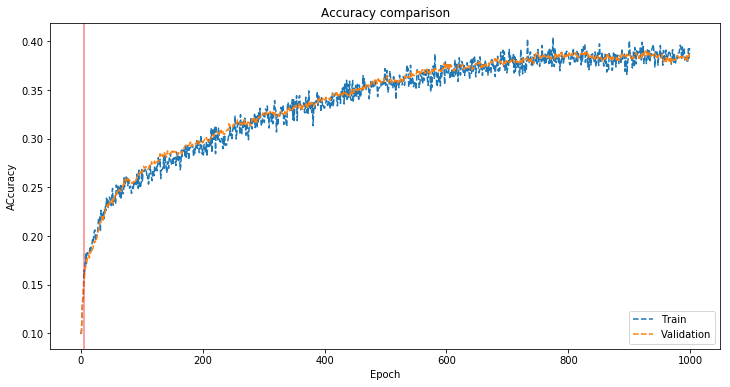

In [48]:
results = read_folder('../../results/SSA/cifar10/alexnet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    n_epochs = len(result['train_accuracy'])
    ax.plot(np.arange(0, n_epochs), result['train_accuracy'], '--', label='Train')
    ax.plot(np.arange(0, n_epochs), result['validation_accuracy'], '--', label='Validation')

    for drop in drop_eps.keys():
        plt.axvline(x=drop, color='red', alpha=0.5)
plt.title('Accuracy comparison')
plt.xlabel('Epoch')
plt.ylabel('ACcuracy')
ax.legend()
plt.show()

## 4. Conclusioni
In generale nei vari test si può notare come SA tenda a saturare prima che venga raggiunto il minimo della funzione obiettivo, mentre SGD raggiunge sempre lo 0. Seppure il valore di $\epsilon$ rimanga costante (1e-4) durante l'allenamento, le mosse random man mano che si procede nell'allenamento diventano sempre meno efficaci e i miglioramenti sono molto piccoli. Bisognerebbe dunque provare nuovi metodi per generare la mossa e abbasare il livello in cui l'allenamento satura al fine di raggiungere una accuracy comparabile a SGD sul training set. In tal modo si potrebbe dopo verificare se vegna ridotto l'overfitting o meno.